In [1]:
import numpy as np
import networkx as nx



# Question 1

In [2]:
!curl -L 'http://snap.stanford.edu/data/ca-GrQc.txt.gz' -o "graph_dataset.gz"
!gunzip -f "graph_dataset.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  106k  100  106k    0     0  53967      0  0:00:02  0:00:02 --:--:-- 53982


In [3]:
class ErdosRenyi:

    def __init__(self, number_of_nodes, number_of_edges):
        '''
        m => number of nodes
        n => number of edges
        '''
        self.m = number_of_nodes
        self.n = number_of_edges
        self.create_graph()


    def create_graph(self):
        all_candidates = np.array([(i, j) for i in range(self.m) for j in range(i+1, self.m)])

        chosen_indices = np.random.choice(len(all_candidates), self.n, replace=False)

        self.graph = nx.from_edgelist(all_candidates[chosen_indices])

    def plot_graph(self):
        nx.draw(self.graph)

class SmallWorldRandomGraph:

    def __init__(self, nodes, shortcuts):
        self.m = nodes
        self.extra_shortcuts = shortcuts
        self.create_graph()

    def create_graph(self):
        self.graph = nx.empty_graph(self.m)

        # Create a circular lattice (a-b-c-a)
        for i in range(self.m):
            self.graph.add_edge(i,(i+1) % self.m)

        # Introduce short circuited edges
        for i in range(self.m):
            self.graph.add_edge(i, (i+2)%self.m)
            

        # Introduce random edges among the unconnected nodes
        max_allowed_shortcuts = self.m * (self.m-1)//2 - self.graph.number_of_edges()

        if self.extra_shortcuts > max_allowed_shortcuts: # 2 * m because of the addition of m edges in the first two steps
            raise ValueError(f"Shortcuts cannot be more then maximum number of shortcuts {max_allowed_shortcuts}")
        
        added = 0
        while added < self.extra_shortcuts:
            u, v = np.random.randint(0, self.m), np.random.randint(0, self.m)
            if u == v or self.graph.has_edge(u, v):
                continue
            self.graph.add_edge(u,v)
            added += 1


        
er_graph = ErdosRenyi(5242, 14484)
small_word_graph = SmallWorldRandomGraph(5242, 4000)
rw_collaboration_graph = nx.read_edgelist("graph_dataset")

# Remove the self edge in rw graph
for node in rw_collaboration_graph.nodes:
    if node in rw_collaboration_graph.adj[node]:
        rw_collaboration_graph.remove_edge(node, node)


## 1.1

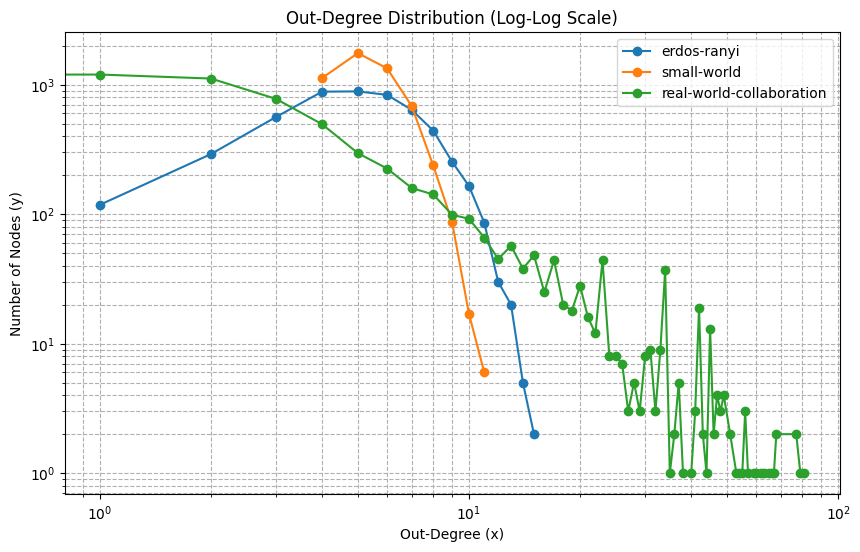

In [4]:
import matplotlib.pyplot as plt
import collections

plt.figure(figsize=(10, 6))
def plot_degree_distribution(G, label):
    degrees = [degree for node, degree in G.degree()]
    degree_counts = collections.Counter(degrees)

    # Sort the degree_counts by degree
    sorted_degree_counts = sorted(degree_counts.items())

    # Extract degrees and their counts
    degrees, counts = zip(*sorted_degree_counts)

    # Plot on a log-log scale
    plt.loglog(degrees, counts, marker='o', linestyle='-', label=label)

plot_degree_distribution(er_graph.graph, 'erdos-ranyi')
plot_degree_distribution(small_word_graph.graph, 'small-world')
plot_degree_distribution(rw_collaboration_graph, 'real-world-collaboration')

plt.title('Out-Degree Distribution (Log-Log Scale)')
plt.xlabel('Out-Degree (x)')
plt.ylabel('Number of Nodes (y)')
plt.legend()
plt.grid(True, which="both", ls="--")

In [5]:
def calculate_average_clustering_coefficient(G):

    average_clustering_coefficient = 0

    for node in G.nodes:
        neighbours = G.adj[node]
        neighbour_edges = set()

        if G.degree(node) < 2:
            continue

        neighbour_edges = set()
        for neighbour in neighbours:
            for neighbour_of_neighbour in G.adj[neighbour]:
                if neighbour_of_neighbour in neighbours and neighbour != node and neighbour_of_neighbour != neighbour:
                    a, b = neighbour, neighbour_of_neighbour
                    if a > b:
                        b,a = a,b
                    neighbour_edges.add((a,b))
        e = len(neighbour_edges)
        average_clustering_coefficient += 2 * e / (G.degree(node) * (G.degree(node) - 1))



    return average_clustering_coefficient / len(G.nodes) 

print(calculate_average_clustering_coefficient(er_graph.graph))
print(calculate_average_clustering_coefficient(small_word_graph.graph))
print(calculate_average_clustering_coefficient(rw_collaboration_graph))

0.0010404516058023143
0.2837523185195789
0.529635811052136


# Question 2 :  Structural Roles: Rolx and ReFex

In [6]:
!curl -L "http://www-personal.umich.edu/~mejn/netdata/netscience.zip" -o "netscience.zip"
!unzip -o "netscience.zip" -d netscience

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   246  100   246    0     0    254      0 --:--:-- --:--:-- --:--:--   254
100 28408  100 28408    0     0   7489      0  0:00:03  0:00:03 --:--:-- 15923
Archive:  netscience.zip
  inflating: netscience/netscience.gml  
  inflating: netscience/netscience.txt  


In [7]:
ns_graph = nx.read_gml("netscience/netscience.gml", label='id')
ns_graph = nx.Graph(ns_graph.to_undirected())
for _, _, d in ns_graph.edges(data=True):
    d.clear()

## 2.1 Basic Features

We begin by loading the graph G provided in the bundle and computing three basic features for
the nodes. For each node v, we choose 3 basic local features (in this order):
1. the degree of v, i.e., deg(v);
2. the number of edges in the egonet of v, where egonet of v is defined as the subgraph of G
induced by v and its neighborhood;
3. the number of edges that connect the egonet of v and the rest of the graph, i.e., the number
of edges that enter or leave the egonet of v.

In [8]:
from heapq import heappush, heappop

def get_basic_feature_vector(G, node):
    feature_vector = []

    # 1 degree f the node
    feature_vector.append(G.degree(node))

    # 2 number of edges in the egonet (node and it's immediate neighbours, and the edges that connect themselves)

    egonet = set(G.adj[node]) | {node}
    egonet_within_edges = 0
    seen_edges = set()
    for u in egonet:
        for v in G.adj[u]:
            if v in egonet and u != v:
                e = frozenset((u, v)) # Frozen set ensures (u, v) == (v, u)
                if e not in seen_edges:
                    seen_edges.add(e)
                    egonet_within_edges += 1
    feature_vector.append(egonet_within_edges)

    # 3 the number of edges that connect the egonet of v and the rest of the graph, i.e., the number of edges that enter or leave the egonet of v.

    egonet_outside_edges = 0
    for u in egonet:
        for v in G.adj[u]:
            if v not in egonet:
                egonet_outside_edges += 1
    feature_vector.append(egonet_outside_edges)

    return feature_vector

def norm_vector(vec_a):
    total_squared_sum = 0
    for component in vec_a:
        total_squared_sum += component ** 2
    return np.sqrt(total_squared_sum)

def dot_product(vec_a, vec_b):
    total_prod_sum = 0
    for comp_a, comp_b in zip(vec_a, vec_b):
        total_prod_sum += comp_a * comp_b
    return total_prod_sum

def get_similarity_score(vec_a, vec_b):
    norm_a = norm_vector(vec_a)
    norm_b = norm_vector(vec_b)

    if not norm_a or not norm_b:
        return 0

    return (dot_product(vec_a=vec_a, vec_b=vec_b)/(norm_a * norm_b)).item()

feature_vectors = {}
for node in ns_graph:
    feature_vectors[node] = get_basic_feature_vector(ns_graph, node)

#Compute the basic feature vector for the node with ID 9, and report the top 5 nodes that are most similar to 9
similarity_scores = []
feature_vector_source = feature_vectors[9]

for node in ns_graph:
    if node != 9:
        feature_vector_node = feature_vectors[node]
        similarity_scores.append([get_similarity_score(feature_vector_source, feature_vector_node), node])
    
similarity_scores.sort()

print(f"The feature vector of node 9 is {feature_vectors[9]}")
print(f"The top 5 nodes most similar to 9 are {[node for score, node in similarity_scores[-5:]]}")
print(similarity_scores[-5:])


The feature vector of node 9 is [6, 10, 1]
The top 5 nodes most similar to 9 are [1054, 1336, 286, 288, 415]
[[0.9961182380000687, 1054], [0.9961182380000687, 1336], [0.996343680627828, 286], [0.996343680627828, 288], [0.9996157540684272, 415]]


## 2.2 Recursive Features [8 points]



In [9]:
def add_two_vector(vec_a, vec_b):
    sum_vector = []
    for comp_a, comp_b in zip(vec_a, vec_b):
        sum_vector.append(comp_a + comp_b)
    return sum_vector

def cal_mean_vector(G, node, feature_vector_map):
    neighbours = list(G.adj[node])
    mean_vector = [0] * len(feature_vector_map[node])

    if not neighbours:
        return mean_vector
    
    for u in neighbours:
        u_vec = feature_vector_map[u]
        mean_vector = add_two_vector(mean_vector, u_vec)
    
    N = len(neighbours)
    for idx in range(len(mean_vector)):
        mean_vector[idx] /= N

    return mean_vector

def cal_sum_vector(G, node, feature_vector_map):

    neighbours = list(G.adj[node])
    sum_vector = [0] * len(feature_vector_map[node])

    if not neighbours:
        return sum_vector
    
    for u in neighbours:
        u_vec = feature_vector_map[u]
        sum_vector = add_two_vector(sum_vector, u_vec)

    return sum_vector

k = 2
for iteration in range(k):
    temp_feature_vectors = feature_vectors.copy()
    for node in ns_graph.nodes:
        temp_feature_vectors[node] = feature_vectors[node] + cal_mean_vector(ns_graph, node, feature_vectors) + cal_sum_vector(ns_graph, node, feature_vectors)
    feature_vectors = temp_feature_vectors.copy()

# Compute the basic feature vector for the node with ID 9, and report the top 5 nodes that are most similar to 9

similarity_scores = []
feature_vector_source = feature_vectors[9]

for node in ns_graph:
    if node != 9:
        feature_vector_node = feature_vectors[node]
        similarity_scores.append([get_similarity_score(feature_vector_source, feature_vector_node), node])
    
similarity_scores.sort()

print(f"The feature vector of node 9 is {feature_vectors[9]}")
print(f"The top 5 similarity scores are {[score for score, node in similarity_scores[-5:]]}")
print(f"The top 5 nodes most similar to 9 are {[node for score, node in similarity_scores[-5:]]}") 

The feature vector of node 9 is [6, 10, 1, 2.5, 4.333333333333333, 4.0, 15, 26, 24, 2.5, 4.333333333333333, 4.0, 4.319444444444444, 7.347222222222222, 2.388888888888889, 10.166666666666666, 17.5, 6.5, 15, 26, 24, 25.916666666666664, 44.083333333333336, 14.333333333333332, 61, 105, 39]
The top 5 similarity scores are [0.9922413199302673, 0.9922839741918226, 0.993728442523926, 0.9946130044020558, 0.9959848829010806]
The top 5 nodes most similar to 9 are [25, 496, 415, 537, 973]


## 2.3 Role Discovery 

### 2.3 a

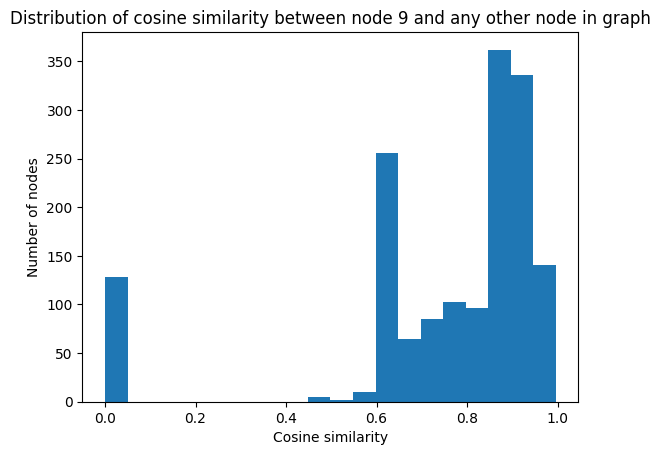

In [10]:
import matplotlib.pyplot as plt

'''
Question a : (a) Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and
any other node in the graph (according to their recursive feature vectors). Note here that the x-axis
is cosine similarity with node 9, and the y-axis is the number of nodes. [3 points]
'''

plt.hist([score for score, node in similarity_scores], bins=20)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of nodes')
plt.title('Distribution of cosine similarity between node 9 and any other node in graph')
plt.show()

### 2.3 b

In [11]:
peaks = [0, 0.4, 0.85, 0.9]

threshold = 0.1

sampled_nodes = []

i = 0
for peak in peaks:
    for score, node in similarity_scores:

        if peak - threshold <= score <= peak + threshold:
            sampled_nodes.append(node)
            break

# Create sub graph
sub_graph = nx.empty_graph()
# sub_graph.add_node(9)

def bfs(queue, G1, G2, limit=2):
    k = 0
    while queue:
        
        if k > limit:
            break
        for _ in range(len(queue)):
            curr_node, curr_parent = queue.pop(0)
            G2.add_edge(curr_parent, curr_node)
            for adj_node in G1.adj[curr_node]:
                if adj_node == curr_parent:
                    continue
                queue.append((adj_node, curr_node))

        k += 1
sampled_nodes

[19, 641, 1536, 162]

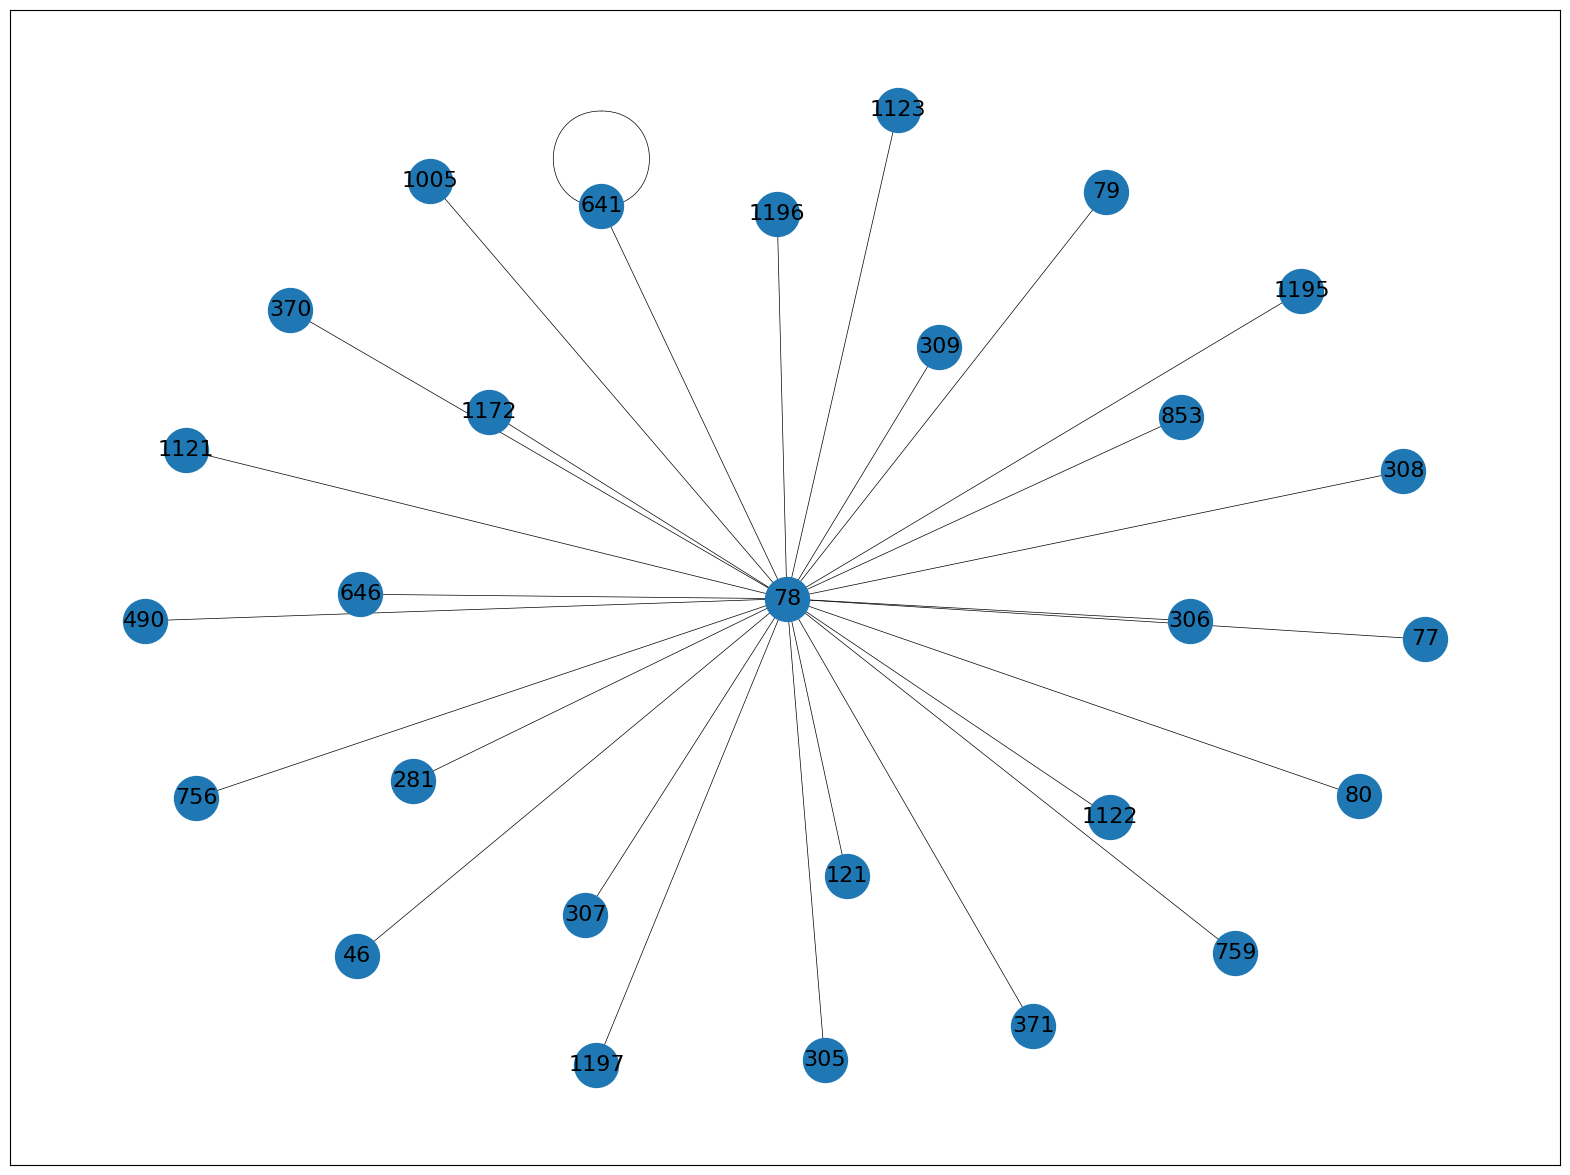

In [12]:

queue = [(641, 641)]
# for node in sampled_nodes:
#     queue.append((node, 9))

bfs(queue, ns_graph, sub_graph, 2)

plt.figure(figsize=(20,15))
nx.draw_networkx(sub_graph,
                 node_size=1000,
                 font_size=16,
                 width=0.5,
                 arrowsize=10,
                 with_labels=True)

Feature vectors

for 641

index-0 : 1 => Only one node is connected with the node 641

index-1 : 1 => Only one edge exist in the egonet (node and its immediate neighbours)

index-2 : 26 => 26 edges are exiting the egonet of node 641, i.e node 641 is a leaf node connected with a highly dense node

# Bonus content : Clustering and visualization

In [13]:
from collections import defaultdict
from sklearn.metrics import pairwise_distances # Not implemented from scratch because this is out of scope for the graph module, might implement from scratch later on

########### LLM GENERATED CRAP, BECAUSE SILHOUTTE SCORE ON MAC ARE UNSTABLE ####################
def _ensure_float_matrix(data: np.ndarray) -> np.ndarray:
    """Return a finite, 2-D float64 view of the input data."""
    array = np.asarray(data, dtype=np.float64)
    if array.ndim == 1:
        array = array.reshape(-1, 1)
    if array.ndim != 2:
        raise ValueError(f"Expected 1-D or 2-D data, got shape {array.shape}")
    if not np.isfinite(array).all():
        raise ValueError("Input data contains NaN or Inf values.")
    return array

def silhouette_score_safe(data: np.ndarray, labels: np.ndarray) -> float:
    """Pure NumPy silhouette score to avoid the BLAS matmul warnings."""
    data = _ensure_float_matrix(data)
    labels = np.asarray(labels)
    if data.shape[0] != labels.shape[0]:
        raise ValueError("Data and labels must have the same number of rows.")
    unique_labels = np.unique(labels)
    if unique_labels.size < 2:
        raise ValueError("Silhouette score needs at least 2 distinct clusters.")

    pairwise = np.linalg.norm(data[:, None, :] - data[None, :, :], axis=2)
    silhouettes = np.empty(len(data), dtype=np.float64)

    for idx, label in enumerate(labels):
        same_mask = labels == label
        same_mask[idx] = False
        if same_mask.any():
            a = pairwise[idx, same_mask].mean()
        else:
            a = 0.0  # Cluster of size 1.
        b = np.inf
        for other in unique_labels:
            if other == label:
                continue
            other_mask = labels == other
            if other_mask.any():
                b = min(b, pairwise[idx, other_mask].mean())
        denom = max(a, b)
        silhouettes[idx] = 0.0 if denom == 0 else (b - a) / denom

    return float(np.mean(silhouettes))
####################################################################################################


class KMeans:

    def __init__(self, k, data):
        self.k = k
        self.data = np.array(data)
        if self.data.ndim == 1:           # make 1-D data into (M,1)
            self.data = self.data.reshape(-1, 1)
        self.assign_random_cluster_centers()

    def assign_random_cluster_centers(self):
        random_indices = np.random.choice(self.data.shape[0], size=self.k, replace=False)
        self.centers = self.data[random_indices]

    def assign_points_to_cluster_centers(self, distance_matrix):
        '''
        distance_matrix => MxN
        labels => M,
        '''
        labels = np.argmin(distance_matrix, axis=1)
        return labels

    def calculate_new_cluster_centers(self, labels):
        hmap = {i : [] for i in range(self.k)}
        # Calculate groups of cluster center to point
        for data_idx, label in enumerate(labels):
            hmap[label].append(self.data[data_idx])


        new_cluster_centers = np.empty((self.k, self.data.shape[1]), dtype=np.float64)

        for label in range(self.k):
            points = hmap[label]
            if points:
                new_cluster_centers[label] = np.mean(points, axis=0)
            else:
                new_cluster_centers[label] = self.data[np.random.randint(0, self.data.shape[0])]
        
        self.centers = new_cluster_centers

    def calculate_distance_matrix(self):
        # Same logic as the below function.
        # LLM Generated crap of the same logic, basically to avoid the cublas, mac is a nightmare with numpy!
        """Return pairwise distances without relying on blas.matmul.

        We use the identity ‖x - c‖² = ‖x‖² + ‖c‖² - 2·x·c with three einsums:
        * `x2` sums the row-wise squared norms of the data, yielding shape (M, 1)
          after `[:, None]`. Broadcasting this over clusters replicates each row.
        * `c2` is the cluster-center analogue with shape (1, K); broadcasting
          copies it down the sample dimension.
        * `cross` is the 2·(x·c) term with shape (M, K).
        Subtracting `cross` from the broadcasted `x2 + c2` produces every
        pairwise squared distance without ever forming the full (M, K, N)
        difference tensor or touching the buggy Accelerate matmul path.
        """
        x2 = np.einsum("ij,ij->i", self.data, self.data)[:, None]
        c2 = np.einsum("ij,ij->i", self.centers, self.centers)[None, :]
        cross = 2.0 * np.einsum("ik,jk->ij", self.data, self.centers)
        dist_sq = x2 + c2 - cross
        np.maximum(dist_sq, 0.0, out=dist_sq)
        distances = np.sqrt(dist_sq, out=dist_sq)
        if not np.isfinite(distances).all():
            raise FloatingPointError("Non-finite distances detected.")
        return distances

    def calculate_distance_matrix_mac_unsafe(self):
        # Fails on mac, if not on mac feel free to use.
        '''
        ON MAC THIS FUNCTION WILL YEILD OVERFLOWS, BECAUSE OF ACCELERATE BLAS

        There is a nice trick to compute the distance quickly using the identity

        norm(x-c) = sqrt(x**2 + c**2 - 2 x.T @ c)

        x => m x n
        c => k x n

        LLM Generated explaination below
        # Broadcasting walkthrough for pairwise distances using the identity:
        #   ||x - c||^2 = ||x||^2 + ||c||^2 - 2 (x · c)
        #
        # Example matrices:
        #   X = [[1, 2],
        #        [3, 4]]                # shape (M=2, N=2)
        #
        #   C = [[0, 1],
        #        [2, 1],
        #        [0, 0]]                # shape (K=3, N=2)
        #
        # Step 1: Row-wise squared norms (keepdims to make them 2-D for broadcasting)
        #   X2 = (X**2).sum(axis=1, keepdims=True)  -> shape (2,1)
        #   X2 = [[ 5],
        #         [25]]
        #
        #   C2 = (C**2).sum(axis=1, keepdims=True).T -> shape (1,3)
        #   C2 = [[1, 5, 0]]
        #
        # Step 2: All pairwise dot products (matrix multiply)
        #   G = X @ C.T  -> shape (2,3)
        #   G = [[ 2,  4, 0],
        #        [ 4, 10, 0]]
        #
        # Step 3: Conceptual broadcasting to (2,3) (NumPy does not copy; this is how it *acts*)
        #   X2 broadcasts across columns:
        #     X2_b = [[ 5,  5,  5],
        #             [25, 25, 25]]            # (2,3)
        #
        #   C2 broadcasts across rows:
        #     C2_b = [[1, 5, 0],
        #             [1, 5, 0]]                # (2,3)
        #
        # Step 4: Combine via the identity (elementwise)
        #   2*G = [[ 4,  8, 0],
        #          [ 8, 20, 0]]
        #
        #   D2 = X2_b + C2_b - 2*G
        #      = [[(5+1-4),  (5+5-8),  (5+0-0)],
        #         [(25+1-8), (25+5-20), (25+0-0)]]
        #      = [[ 2,  2,  5],
        #         [18, 10, 25]]                 # shape (2,3)
        #
        # Step 5: Euclidean distances
        #   D = sqrt(D2)
        #     = [[1.4142, 1.4142, 2.2361],
        #        [4.2426, 3.1623, 5.0000]]
        #
        # Broadcasting rule reminder (align from the right):
        #   (2,1) + (1,3) -> (2,3) because:
        #     - last dims: 1 and 3  -> broadcast to 3
        #     - next dims: 2 and 1  -> broadcast to 2
        
        '''
        X2 = (self.data ** 2).sum(axis=1, keepdims=True)  # X => M x N, X2 => M x 1
        C2 = (self.centers ** 2).sum(axis=1, keepdims=True).T # C => K x N => 1 x N

        product = 2 * self.data @ self.centers.T # M x K

        distance_matrix = X2 + C2 - product
        np.maximum(distance_matrix, 0.0, out=distance_matrix)

        return np.sqrt(distance_matrix, out=distance_matrix)

    def fit(self, epochs):

        for epoch in range(epochs):
            distance_matrix = self.calculate_distance_matrix()
            labels = self.assign_points_to_cluster_centers(distance_matrix)
            self.calculate_new_cluster_centers(labels)
        
        return labels
    
    def get_best_k(self, epochs=50, lower_limit=2, upper_limit=50, num_of_experiments=3):

        best_k, best_score = None, -np.inf

        for k in range(lower_limit, upper_limit + 1):
            runs = []
            for experiment in range(num_of_experiments):
                self.k = k
                self.assign_random_cluster_centers()
                labels = self.fit(epochs)
                if len(np.unique(labels)) < 2:
                    continue
                score = silhouette_score_safe(self.data, labels)
                runs.append(score)
            if runs:
                mean_score = np.mean(runs)
                
                if mean_score > best_score:
                    best_k = k
                    best_score = mean_score
        self.k = best_k
        return best_k, best_score

In [14]:
from sklearn.preprocessing import StandardScaler

feature_matrix = []
for node in ns_graph.nodes:
    feature_matrix.append(feature_vectors[node])


X = np.array(feature_matrix, dtype=np.float64)
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X) # We need to do scaling with k-means, because k means has the assumption that all feature have the same variance, because it gives all feature equal importance regardless of their scale



kmeans_obj = KMeans(k=10, data=X)
kmeans_obj.get_best_k(epochs=100, lower_limit=2, upper_limit=10)


labels = KMeans(k=3, data=X).fit(100)

In [15]:
np.unique(labels)

array([0, 1, 2])

## Bonus : Visualization of cluster of nodes (Here it will be roles instead of community)

# Bonus content : Louvanian Algorithm

In [16]:
from collections import defaultdict

class Louvain:

    def __init__(self, graph):
        '''
        We will save all the labels of node at each level, because its a hierarchical clustering technique.
        '''

        self.dendrogram = None
        self.graph = graph
        self.C = set()          # Community ids
        self.sig_in = dict()        # Edges inside a community, i.e sum of all edges where the source and the destination nodes are inside the community
        self.sig_tot = dict()       # sum of all edges where the source node is inside the community
        self.node_to_community = dict()

        # Degree map from node to degree of the node (weighted degree [sum of weighted edges])
        self.k = {node : self.graph.degree(node, weight='weight') for node in self.graph.nodes} # This will gather the weighted degree for each node
        self.m2 = float(sum(self.k.values())) # 2 * m

        


    def calculate_delta_first_term(self, u, comm_a, comm_b):
        sig_uin_b = sum(
            self.graph[u][v].get('weight', 1.0) # Sum over all the edges which has destination inside the community b, and source u
            for v in self.graph[u] # Iterate over all the neighbours of u
            if self.node_to_community[v] == comm_b # Filter out those neighbours of u that are not in b
            )
        
        sig_uin_a = sum(
            self.graph[u][v].get('weight', 1.0) # Sum over all the edges which has destination inside the community b, and source u
            for v in self.graph[u] # Iterate over all the neighbours of u
            if self.node_to_community[v] == comm_a # Filter out those neighbours of u that are not in a
        )
        
        return 2 * (sig_uin_b - sig_uin_a) / self.m2

    def calculate_delta_second_term(self, u, comm_a, comm_b):
        delta_sig = (self.sig_tot[comm_a] - self.sig_tot[comm_b])
        return 2.0 * ( (self.k[u] * delta_sig - (self.k[u] ** 2)) / (self.m2 ** 2) )

    def calculate_delta_q(self, u, comm_a, comm_b):
        return self.calculate_delta_first_term(u, comm_a, comm_b) + self.calculate_delta_second_term(u, comm_a, comm_b)
    


    def first_pass(self):
        for super_node in self.graph.nodes:
            self.C.add(super_node)
            self.node_to_community[super_node] = super_node

            if self.graph.has_edge(super_node, super_node):
                w = self.graph[super_node][super_node].get('weight', 1.0)
            else:
                w = 0.0
            
            self.sig_in[super_node] = 2.0 * w
            self.sig_tot[super_node] = self.k[super_node]
        
        while True:
            moved = False
            super_nodes = list(self.graph.nodes)
            np.random.shuffle(super_nodes)

            for super_node in super_nodes:
                max_q, best_comm = -float('inf'), None
                candidate_comm = {self.node_to_community[v] for v in self.graph[super_node]}
                # For this node, we need to find the neighbouring community that are not it's current community
                for comm in candidate_comm:
                    if comm != self.node_to_community[super_node]:
                        delta_q = self.calculate_delta_q(super_node, self.node_to_community[super_node], comm)
                        if delta_q > max_q:
                            max_q = delta_q
                            best_comm = comm
                    
                if max_q > 0:
                    curr_comm = self.node_to_community[super_node]
                    
                    self.sig_tot[curr_comm] -= self.k[super_node] # The weighted degree of the super node
                    self.sig_in[curr_comm] -= 2.0 * sum(self.graph[super_node][v].get('weight', 1.0) for v in self.graph[super_node] if self.node_to_community[v] == curr_comm)

                    self.sig_tot[best_comm] += self.k[super_node]
                    self.sig_in[best_comm] += 2.0 * sum(self.graph[super_node][v].get('weight', 1.0) for v in self.graph[super_node] if self.node_to_community[v] == best_comm)

                    self.node_to_community[super_node] = best_comm
                    moved = True
            if not moved:
                break
        

    def second_pass(self):
        
        new_communities = set(self.node_to_community.values())
        current_modularity = 0.0
        for comm in new_communities: # Sum over active communities (current partition) to avoid empty/stale IDs and ensure correct modularity. Can have numerical precision error creeping in, or other book keeping errors.
            current_modularity += (self.sig_in[comm] / self.m2) - (self.sig_tot[comm] / self.m2) ** 2
        print(f"The current modularity of the clusters are : {current_modularity}")

        # Merging the communities
        new_graph = nx.Graph()
        new_graph.add_nodes_from(new_communities)

        for u, v, data in self.graph.edges(data=True):
            cu = self.node_to_community[u]
            cv = self.node_to_community[v]
            w = data.get('weight', 1.0)

            if new_graph.has_edge(cu, cv):
                new_graph[cu][cv]['weight'] += w
            else:
                new_graph.add_edge(cu, cv, weight=w)

        self.graph = new_graph
        # Reset the graph properties
        self.C.clear()        # Community ids
        self.sig_in.clear()        # Edges inside a community, i.e sum of all edges where the source and the destination nodes are inside the community
        self.sig_tot.clear()       # sum of all edges where the source node is inside the community
        self.node_to_community.clear()

        # Degree map from node to degree of the node (weighted degree [sum of weighted edges])
        self.k = {node : self.graph.degree(node, weight='weight') for node in self.graph.nodes} # This will gather the weighted degree for each node
        self.m2 = float(sum(self.k.values())) # 2 * m

    def fit(self, epochs):

        for epoch in range(epochs):
            curr_nodes = list(self.graph.nodes).copy()
            self.first_pass()
            self.second_pass()
            new_nodes = list(self.graph.nodes).copy()

            if curr_nodes == new_nodes:
                print("Converged")
                break
        
louvain_obj = Louvain(ns_graph)
louvain_obj.fit(epochs=30)

            

The current modularity of the clusters are : 0.8546791647979566
The current modularity of the clusters are : 0.8716036067525639
The current modularity of the clusters are : 0.9004146935505214
Converged


In [17]:
## LLM GENERATED CRAP, NEED TO VISUALIZE FOR MOTIVATION, VISUALIZATION OF THE ENTIRE NETWORK IS NOT DONE YET


import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def draw_partition(G, node_to_community, pos=None, title="Louvain partition", max_legend=15):
    """
    Color nodes by node_to_community on graph G.
    Call this right after first_pass() (or stash a copy of node_to_community before second_pass() clears it).
    """
    if not node_to_community:
        raise ValueError("node_to_community is empty. Call after first_pass() or save a copy before second_pass().")

    # Layout (stable if you pass a precomputed pos)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Communities and colors
    comms = sorted(set(node_to_community.values()), key=lambda c: str(c))
    cmap = plt.cm.get_cmap("tab20", len(comms))
    color_of = {c: cmap(i) for i, c in enumerate(comms)}
    node_colors = [color_of[node_to_community[n]] for n in G.nodes()]

    # Edge widths by weight (light)
    widths = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
    # Normalize edge widths a bit for display
    if widths:
        w = np.array(widths, dtype=float)
        w = 0.5 + 1.5 * (w - w.min()) / (w.max() - w.min() + 1e-9)
        widths = w.tolist()
    else:
        widths = 0.5

    # Node sizes by (weighted) degree (optional)
    deg = dict(G.degree(weight="weight"))
    node_sizes = [50 + 50 * np.sqrt(deg.get(n, 1.0)) for n in G.nodes()]

    # Draw
    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, ax=ax, width=widths, edge_color="#888888", alpha=0.4)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes, linewidths=0.5, edgecolors="black")

    # Community labels at centroids
    for c in comms[:max_legend]:
        nodes_c = [n for n in G.nodes() if node_to_community[n] == c]
        if not nodes_c: 
            continue
        xy = np.array([pos[n] for n in nodes_c])
        cx, cy = xy.mean(axis=0)
        ax.text(cx, cy, str(c), fontsize=9, weight="bold", ha="center", va="center", alpha=0.9)

    # Legend (truncate if too many)
    if len(comms) <= max_legend:
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(c),
                               markerfacecolor=color_of[c], markeredgecolor="black", markersize=8)
                   for c in comms]
        ax.legend(handles=handles, title="Communities", loc="upper right", frameon=True)

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

/var/folders/j6/ft6nmx8n1nq6fsz73fs5nyxr0000gn/T/ipykernel_1525/3278368488.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(comms))


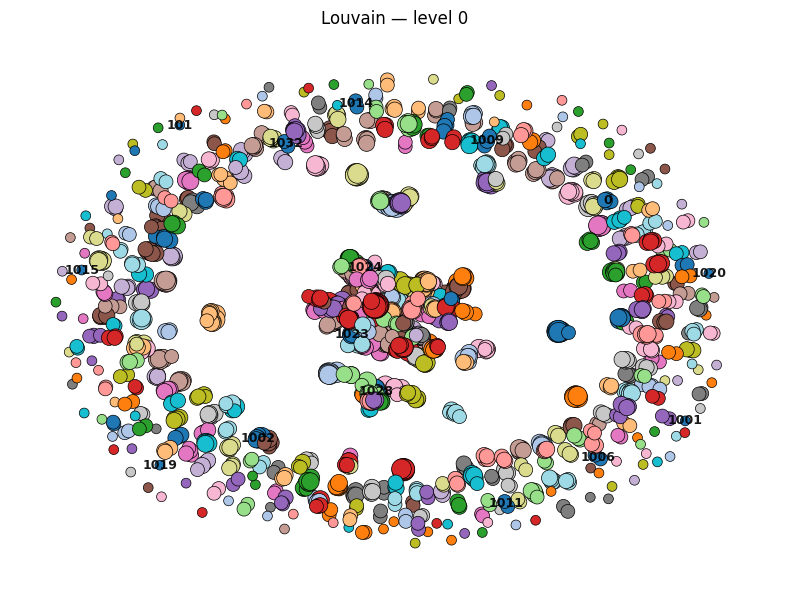

The current modularity of the clusters are : 0.8536882840925454


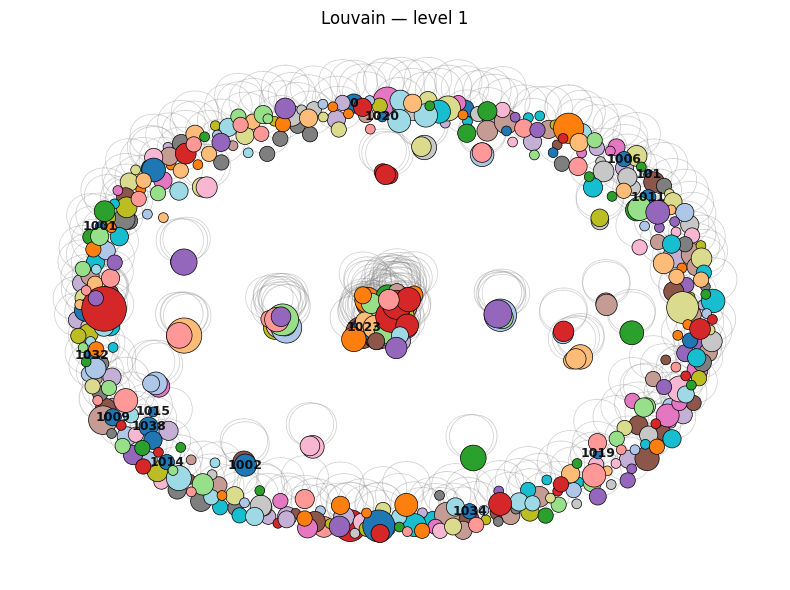

The current modularity of the clusters are : 0.8672971328035495


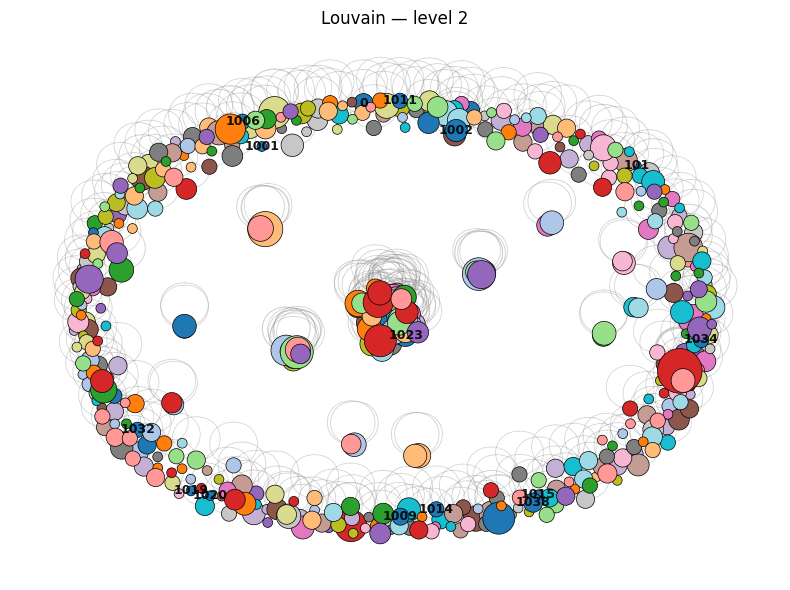

The current modularity of the clusters are : 0.884437905961828


In [18]:
louvain = Louvain(ns_graph)

for epoch in range(3):
    louvain.first_pass()  # builds node_to_community for level 0
    draw_partition(louvain.graph, louvain.node_to_community, title=f"Louvain — level {epoch}")
    louvain.second_pass()  # contracts to next level



In [44]:
class SpectralClustering:

    def __init__(self, graph):
        self.graph = graph
        self.adj_mat = nx.to_numpy_array(graph)

    def get_laplacian(self):
        self.degree_matrix = np.diag([self.graph.degree(node) for node in self.graph])
        self.laplacian =  self.degree_matrix - self.adj_mat

    def calculate_eigen_components(self):
        
        eigen_values, eigen_vectors = np.linalg.eigh(self.laplacian)

        idx_sorted = np.argsort(eigen_values)
        sorted_eigen_values = eigen_values[idx_sorted]
        sorted_eigen_vectors = eigen_vectors[:, idx_sorted]

        self.eigen_values = sorted_eigen_values
        self.eigen_vectors = sorted_eigen_vectors
    
    def find_best_k(self): 
        best_delta = -float('inf')
        best_k = None

        for i in range(1, len(self.eigen_values)):
            delta = self.eigen_values[i] - self.eigen_values[i-1]
            print(best_delta, delta)
            if delta > best_delta:
                best_delta = delta
                best_k = i
        if not best_k:
            best_k = 1
        
        self.k = best_k

    def take_k_components(self):
        self.reduced_laplacian = self.eigen_vectors[:, :self.k]
        
    def apply_k_means_clustering(self, epochs):
        kmeans_obj = KMeans(k=self.k, data=self.reduced_laplacian)
        self.labels = kmeans_obj.fit(epochs)
        return self.labels

    def fit(self, epochs):
        self.get_laplacian()
        self.calculate_eigen_components()
        self.k = 2
        self.take_k_components()
        self.apply_k_means_clustering(epochs)

        return self.labels

Chosen k (number of communities): 2
Cluster sizes: {np.int64(0): np.int64(18), np.int64(1): np.int64(16)}


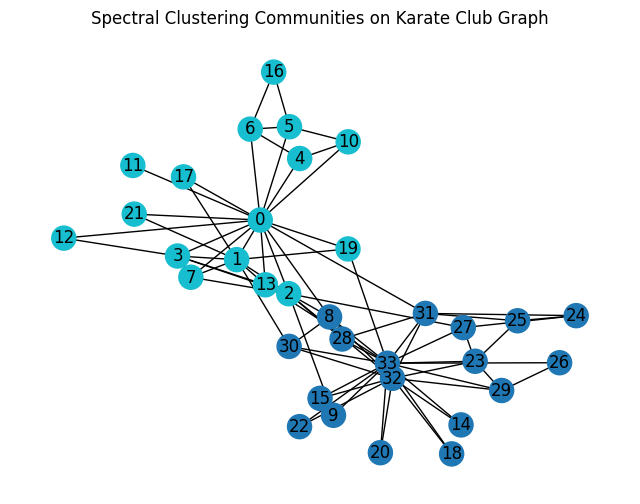

In [45]:
# Build Karate Club graph and run spectral clustering
G = nx.karate_club_graph()
sc = SpectralClustering(G)
labels = sc.fit(epochs=100)

print("Chosen k (number of communities):", sc.k)
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

# Plot with node colors according to cluster labels
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    node_color=labels,
    cmap=plt.cm.tab10,
    with_labels=True
)
plt.title("Spectral Clustering Communities on Karate Club Graph")
plt.axis("off")
plt.show()

In [23]:
np.linalg.eig(t)

EigResult(eigenvalues=array([ 2.17008649+0.j,  4.        +0.j, -1.4811943 +0.j, ...,
        0.        +0.j,  0.        +0.j,  0.        +0.j], shape=(1589,)), eigenvectors=array([[-5.22720726e-01+0.j, -7.94033047e-18+0.j, -3.02028137e-01+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [-6.11628457e-01+0.j, -2.77404933e-16+0.j,  7.49390492e-01+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [-8.32667268e-17+0.j,  4.47213595e-01+0.j,  7.70112793e-17+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       ...,
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.000

In [24]:
len(nx.karate_club_graph().nodes)

34

In [27]:
ns_graph.degree(0)

2